In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import os
from utils import *
from settings import station_locale, data_root, output_folder, report_folder, station_dist, station_angle

In [2]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder

In [3]:
data_folder = '../outputs/'
report_folder = '../report_rc/'
model_folder = '../models/'

## load data

In [4]:
df = pd.read_csv(os.path.join(data_folder, 'train_set.zip'))
df.drop(labels=['Unnamed: 0'], axis=1, inplace=True)

In [5]:
# df['station_id'].unique()

In [6]:
df = df.query('datetime_label>5000')

In [7]:
df.columns

Index(['station_id', 'PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2', 'longitude',
       'latitude', 'local_time', 'date', 'time', 'solar_term', 'time_label',
       'NearTraffic', 'Others', 'SubUrban', 'Urban', 'datetime_label',
       'temperature', 'pressure', 'humidity', 'wind_direction', 'wind_speed'],
      dtype='object')

In [8]:
for i in df['station_id'].unique():
    qry = f'station_id=="{i}"'
    print(f'{i}:', len(df.query(qry)))

aotizhongxin_aq: 6551
badaling_aq: 6551
beibuxinqu_aq: 6551
daxing_aq: 6551
dingling_aq: 6551
donggaocun_aq: 6551
dongsi_aq: 6551
dongsihuan_aq: 6551
fangshan_aq: 6551
fengtaihuayuan_aq: 6551
guanyuan_aq: 6551
gucheng_aq: 6551
huairou_aq: 6551
liulihe_aq: 6551
mentougou_aq: 6551
miyun_aq: 6551
miyunshuiku_aq: 6551
nansanhuan_aq: 6551
nongzhanguan_aq: 6551
pingchang_aq: 6551
pinggu_aq: 6551
qianmen_aq: 6551
shunyi_aq: 6551
tiantan_aq: 6551
tongzhou_aq: 6551
wanliu_aq: 6551
wanshouxigong_aq: 6551
xizhimenbei_aq: 6551
yanqin_aq: 6551
yizhuang_aq: 6551
yongdingmennei_aq: 6551
yongledian_aq: 6551
yufa_aq: 6551
yungang_aq: 6551
zhiwuyuan_aq: 6551


## Feature Engineering

In [9]:
df['periodic_solar_term'] = df['date'].map(lambda x: get_solar_term(x, periodicity=True))
df['periodic_time'] = df['time'].map(lambda x: get_periodic_time_label(x))

In [10]:
df.columns

Index(['station_id', 'PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2', 'longitude',
       'latitude', 'local_time', 'date', 'time', 'solar_term', 'time_label',
       'NearTraffic', 'Others', 'SubUrban', 'Urban', 'datetime_label',
       'temperature', 'pressure', 'humidity', 'wind_direction', 'wind_speed',
       'periodic_solar_term', 'periodic_time'],
      dtype='object')

In [11]:
# temp = df.query(qry)[useful_cols]
# temp

#### build trainset for each station

In [11]:
stations = df['station_id'].unique()

In [12]:
# use aotizhongxin as example to do analisis
## only use datetime_label > 5000 to avoid too much missing data noise

In [13]:
input_cols = ['temperature', 'pressure', 'humidity',
              'periodic_solar_term', 'periodic_time',
              'NearTraffic', 'Others', 'SubUrban', 'Urban',
              'wind_speed']
output_cols = ['PM2.5', 'PM10', 'O3']
useful_cols = ['temperature', 'pressure', 'humidity',
               'wind_speed', 'wind_direction']

In [14]:
def get_max_dist(station, stations):
    stations = [i for i in stations if i != station]
    station_pairs = [sorted([station, i]) for i in stations]
    station_dists = [station_dist[f'{i[0]}-{i[1]}'] for i in station_pairs]
    return max(station_dists)

In [15]:
base_df = df.query('station_id=="fangshan_aq"')[input_cols]
base_df = base_df.reset_index().drop('index', axis=1)     # index other_df will make column cannot be combined
base_ouputs = df.query('station_id=="aotizhongxin_aq"')[output_cols]
target_station = 'aotizhongxin_aq'

max_dist = get_max_dist(target_station, stations)
for station in stations:
    if station == target_station:
        continue
    short_stt = station.split('_')[0]
    station_pair = sorted([target_station, station])
    dist = station_dist[f'{station_pair[0]}-{station_pair[1]}']
    dist_rate = 1 - (dist/max_dist)
    
    qry = f'station_id=="{station}"'
    other_df = df.query(qry)[useful_cols]
    other_df = other_df.reset_index().drop('index', axis=1)
    
    base_df[f'{short_stt}_temperature'] = other_df['temperature'] * dist_rate
    base_df[f'{short_stt}_pressure'] = other_df['pressure'] * dist_rate
    base_df[f'{short_stt}_humidity'] = other_df['humidity'] * dist_rate
    
    wind_info = other_df[['wind_speed', 'wind_direction']].values.tolist()
    wind_info = [cal_wind_projection(station, target_station, x[0], x[1])*dist_rate for x in wind_info]
    base_df[f'{short_stt}_wind'] = np.array(wind_info) 

In [18]:
base_df.head()

,temperature,pressure,humidity,periodic_solar_term,periodic_time,NearTraffic,Others,SubUrban,Urban,wind_speed,...,yufa_humidity,yufa_wind,yungang_temperature,yungang_pressure,yungang_humidity,yungang_wind,zhiwuyuan_temperature,zhiwuyuan_pressure,zhiwuyuan_humidity,zhiwuyuan_wind
0,29.280131,1005.258541,37.524672,9.184402,22.173109,0,0,0,1,1.636710,...,14.925827,0.0,17.632926,615.098877,28.465721,0.0,22.073195,767.747710,30.933837,0.0
1,28.710492,1005.201344,39.506169,9.184402,20.784610,0,0,0,1,1.601535,...,16.033550,0.0,17.167943,615.070580,30.231355,0.0,21.535720,767.721074,32.714683,0.0
2,28.120462,1005.214075,41.493059,9.184402,19.040480,0,0,0,1,1.506208,...,17.141290,0.0,16.674565,615.103635,33.112322,0.0,21.015652,767.726620,34.792756,0.0
3,27.463233,1005.213925,45.211268,9.184402,16.970563,0,0,0,1,1.295043,...,18.247698,0.0,15.913150,615.134525,37.303507,0.0,20.364053,767.721046,38.246912,0.0
4,26.934848,1005.188283,46.873675,9.184402,14.610274,0,0,0,1,1.041345,...,18.009994,0.0,15.525489,615.164785,38.619800,0.0,19.947218,767.691851,39.763670,0.0


In [16]:
base_ouputs[base_ouputs['PM2.5']<0]

,PM2.5,PM10,O3


In [17]:
temp = base_df[['temperature','pressure','humidity','periodic_solar_term','periodic_time','wind_speed']]
temp[['PM2.5', 'PM10', 'O3']] = base_ouputs[['PM2.5', 'PM10', 'O3']]


/Users/leonling/workspace/pyenv/py36/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [18]:
temp = temp.dropna()

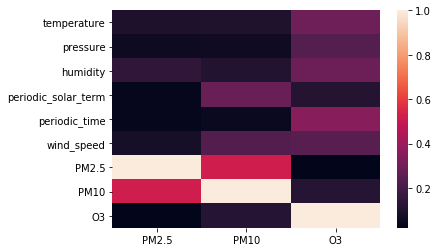

In [19]:
sns.heatmap((temp.corr()).abs()[['PM2.5', 'PM10', 'O3']])

## Model Selection

In [20]:
from sklearn.linear_model import Lasso, Ridge

from sklearn.externals import joblib
from sklearn.model_selection import train_test_split 

from xgboost import XGBRegressor

from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout, Flatten


Using TensorFlow backend.


In [21]:
from evaluation import smape

In [22]:
def split_train_test(x, y, test_rate=0.2):
    size = len(x)
    train_rate = 1 - test_rate
    train_x = x.iloc[:int(size*train_rate),:]
    test_x = x.iloc[int(size*train_rate):,:]
    train_y = y.iloc[:int(size*train_rate),:]
    test_y = y.iloc[int(size*train_rate):,:]
    return train_x, train_y, test_x, test_y

def create_dataset(x, y, lookback=1):
    pass

In [23]:
train_x, train_y, test_x, test_y = split_train_test(base_df, base_ouputs, test_rate=0.3)

### Linear Regression

In [24]:
rgr_pm25 = Ridge(alpha=0.01).fit(train_x, train_y[['PM2.5']])
rgr_pm10 = Ridge(alpha=0.01).fit(train_x, train_y[['PM10']])
rgr_o3 = Ridge(alpha=0.01).fit(train_x, train_y[['O3']])

In [25]:
prediction = test_y.copy()

prediction = prediction.drop(['PM2.5', 'PM10', 'O3'], axis=1)
prediction['PM25'] = rgr_pm25.predict(test_x)
prediction['PM10'] = rgr_pm10.predict(test_x)
prediction['O3'] = rgr_o3.predict(test_x)

print('O3:', smape(test_y['O3'], prediction['O3']))
print('PM10:', smape(test_y['PM10'], prediction['PM10']))
print('PM25:', smape(test_y['PM2.5'], prediction['PM25']))

O3: 0.8752993806110937
PM10: 0.9665258843114611
PM25: 0.437136295016031


In [26]:
lss_pm25 = Lasso(alpha=0.01).fit(train_x, train_y[['PM2.5']])
lss_pm10 = Lasso(alpha=0.01).fit(train_x, train_y[['PM10']])
lss_o3 = Lasso(alpha=0.01).fit(train_x, train_y[['O3']])

/Users/leonling/workspace/pyenv/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/leonling/workspace/pyenv/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/leonling/workspace/pyenv/py36/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [27]:
prediction = test_y.copy()

prediction = prediction.drop(['PM2.5', 'PM10', 'O3'], axis=1)
prediction['PM25'] = lss_pm25.predict(test_x)
prediction['PM10'] = lss_pm10.predict(test_x)
prediction['O3'] = lss_o3.predict(test_x)

print('O3:', smape(test_y['O3'], prediction['O3']))
print('PM10:', smape(test_y['PM10'], prediction['PM10']))
print('PM25:', smape(test_y['PM2.5'], prediction['PM25']))

O3: 2.2497218613551646
PM10: 1.0833408190793716
PM25: -2.644615099173851


### XGBoost

In [21]:
%timeit
xgb_pm25_1 = XGBRegressor(booster='gblinear', n_estimators=1000, learning_rate=0.1, max_depth=5).fit(train_x, train_y[['PM2.5']])
xgb_pm25_2 = XGBRegressor(booster='gblinear', n_estimators=1500, learning_rate=0.1, max_depth=3).fit(train_x, train_y[['PM2.5']])
xgb_pm25_3 = XGBRegressor(booster='gblinear', n_estimators=2000, learning_rate=0.1, max_depth=1).fit(train_x, train_y[['PM2.5']])
xgb_pm10_1 = XGBRegressor(booster='gblinear', n_estimators=1000, learning_rate=0.1, max_depth=5).fit(train_x, train_y[['PM10']])
xgb_pm10_2 = XGBRegressor(booster='gblinear', n_estimators=1500, learning_rate=0.1, max_depth=3).fit(train_x, train_y[['PM10']])
xgb_pm10_3 = XGBRegressor(booster='gblinear', n_estimators=2000, learning_rate=0.1, max_depth=1).fit(train_x, train_y[['PM10']])
xgb_o3_1 = XGBRegressor(booster='gblinear', n_estimators=1000, learning_rate=0.1, max_depth=5).fit(train_x, train_y[['O3']])
xgb_o3_2 = XGBRegressor(booster='gblinear', n_estimators=1500, learning_rate=0.1, max_depth=3).fit(train_x, train_y[['O3']])
xgb_o3_3 = XGBRegressor(booster='gblinear', n_estimators=2000, learning_rate=0.1, max_depth=1).fit(train_x, train_y[['O3']])

In [22]:
prediction = test_y.copy()

prediction = prediction.drop(['PM2.5', 'PM10', 'O3'], axis=1)
prediction['PM25'] = (xgb_pm25_1.predict(test_x)+xgb_pm25_2.predict(test_x)+xgb_pm25_3.predict(test_x))/3
prediction['PM10'] = (xgb_pm10_1.predict(test_x)+xgb_pm10_2.predict(test_x)+xgb_pm10_3.predict(test_x))/3
prediction['O3'] = (xgb_o3_1.predict(test_x)+xgb_o3_2.predict(test_x)+xgb_o3_3.predict(test_x))/3

print('O3:', smape(test_y['O3'], prediction['O3']))
print('PM10:', smape(test_y['PM10'], prediction['PM10']))
print('PM25:', smape(test_y['PM2.5'], prediction['PM25']))

O3: 0.6894773829437219
PM10: 1.042169125529353
PM25: 0.1904784917949952


In [26]:
prediction['PM25'] = xgb_pm25_1.predict(test_x)
print('PM25:', smape(test_y['PM2.5'], prediction['PM25']))
prediction['PM25'] = xgb_pm25_2.predict(test_x)
print('PM25:', smape(test_y['PM2.5'], prediction['PM25']))
prediction['PM25'] = xgb_pm25_3.predict(test_x)
print('PM25:', smape(test_y['PM2.5'], prediction['PM25']))
prediction['PM25'] = (xgb_pm25_3.predict(test_x)+xgb_pm25_2.predict(test_x))/2
print('PM25:', smape(test_y['PM2.5'], prediction['PM25']))

prediction['PM10'] = xgb_pm10_1.predict(test_x)
print('PM10:', smape(test_y['PM10'], prediction['PM10']))
prediction['PM10'] = xgb_pm10_2.predict(test_x)
print('PM10:', smape(test_y['PM10'], prediction['PM10']))
prediction['PM10'] = xgb_pm10_3.predict(test_x)
print('PM10:', smape(test_y['PM10'], prediction['PM10']))
prediction['PM10'] = (xgb_pm10_1.predict(test_x)+xgb_pm10_3.predict(test_x))/2
print('PM10:', smape(test_y['PM10'], prediction['PM10']))

prediction['O3'] = xgb_o3_1.predict(test_x)
print('O3:', smape(test_y['O3'], prediction['O3']))
prediction['O3'] = xgb_o3_2.predict(test_x)
print('O3:', smape(test_y['O3'], prediction['O3']))
prediction['O3'] = xgb_o3_3.predict(test_x)
print('O3:', smape(test_y['O3'], prediction['O3']))

PM25: 0.3941247257058345
PM25: 1.1100672300983399
PM25: 0.3180712077046402
PM25: 0.32924272625073797
PM10: 0.6482869395348424
PM10: 0.8127891851704792
PM10: 0.657716945722753
PM10: 1.8809923808759015
O3: 0.6797168359394902
O3: 0.6954556226819322
O3: 0.6716897308476266


In [28]:
prediction['O3'] = (xgb_o3_3.predict(test_x)+xgb_o3_2.predict(test_x))/2
print('O3:', smape(test_y['O3'], prediction['O3']))

O3: 0.6588684737970282


### LSTM

In [60]:
def build_model(input_dimensions):
    loss_func = 'mse'
    optimiser_func = 'rmsprop' # rmsprop
    activation_func = 'selu'  # linear
    
    rnn_model = Sequential()

    rnn_model.add(LSTM(
                input_dim=input_dimensions,
                output_dim=64,
                return_sequences=True, 
                activation=activation_func))
    rnn_model.add(Dropout(0.2))

    rnn_model.add(LSTM(128, return_sequences=False, activation=activation_func))
    rnn_model.add(Dropout(0.2))

    rnn_model.add(Dense(output_dim=3))
    rnn_model.add(Activation(activation_func))
 
    rnn_model.compile(loss=loss_func, optimizer=optimiser_func)
    return rnn_model

def train_model(model_name, train_x, train_y, test_x, test_y, epoches=100, batch_size=4):
    
    model = build_model(train_x.shape[-1])
    history = model.fit(train_x, train_y, epochs=epoches, batch_size=batch_size, validation_data=(test_x, test_y), verbose=2, shuffle=False)

    model.save(os.path.join(model_folder, f'./{model_name}.h5'))
    return model, history

In [61]:
x_train = train_x.copy().values
x_test = test_x.copy().values
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [65]:
%timeit
lstm, history = train_model('lstm_model', x_train, train_y, x_test, test_y, batch_size=12)

/Users/leonling/workspace/pyenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  if sys.path[0] == '':
/Users/leonling/workspace/pyenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, activation="selu", input_shape=(None, 286..., units=64)`
  if sys.path[0] == '':
/Users/leonling/workspace/pyenv/py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=3)`


Train on 4585 samples, validate on 1966 samples
Epoch 1/100
 - 3s - loss: 3382.7195 - val_loss: 10543.3620
Epoch 2/100
 - 1s - loss: 3323.4299 - val_loss: 9617.1655
Epoch 3/100
 - 1s - loss: 5957.3985 - val_loss: 8204.3170
Epoch 4/100
 - 1s - loss: 2639.6792 - val_loss: 7643.1558
Epoch 5/100
 - 1s - loss: 6501.7278 - val_loss: 8109.4875
Epoch 6/100
 - 1s - loss: 2194.3505 - val_loss: 7105.2460
Epoch 7/100
 - 1s - loss: 9154.2107 - val_loss: 7585.8650
Epoch 8/100
 - 2s - loss: 14671.6641 - val_loss: 7382.3178
Epoch 9/100
 - 2s - loss: 1906.1134 - val_loss: 7588.9988
Epoch 10/100
 - 1s - loss: 1464.0851 - val_loss: 7873.7958
Epoch 11/100
 - 2s - loss: 1454.9160 - val_loss: 7864.7826
Epoch 12/100
 - 1s - loss: 1650.1901 - val_loss: 7382.1240
Epoch 13/100
 - 1s - loss: 1477.8052 - val_loss: 7393.6348
Epoch 14/100
 - 1s - loss: 2970.3018 - val_loss: 7419.3884
Epoch 15/100
 - 1s - loss: 2135.4509 - val_loss: 7267.7099
Epoch 16/100
 - 1s - loss: 2529.1741 - val_loss: 7483.9767
Epoch 17/100
 -

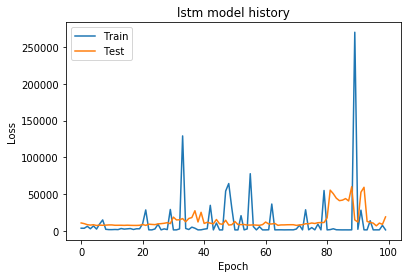

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'lstm model history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [74]:
prediction = test_y.copy()

prediction = prediction.drop(['PM2.5', 'PM10', 'O3'], axis=1)
predicts = lstm.predict(x_test).T
prediction['PM25'] = predicts[0]
prediction['PM10'] = predicts[1]
prediction['O3'] = predicts[2]

print('O3:', smape(test_y['O3'], prediction['O3']))
print('PM10:', smape(test_y['PM10'], prediction['PM10']))
print('PM25:', smape(test_y['PM2.5'], prediction['PM25']))

O3: 2.0961943443821465
PM10: 0.5228026945273635
PM25: 0.5969012589603921


## Model training

In [ ]:
# use xgboost as final model

In [ ]:
xgb_pm25_1 = XGBRegressor(booster='gblinear', n_estimators=1000, learning_rate=0.1, max_depth=5).fit(train_x, train_y[['PM2.5']])
xgb_pm25_3 = XGBRegressor(booster='gblinear', n_estimators=2000, learning_rate=0.1, max_depth=1).fit(train_x, train_y[['PM2.5']])
xgb_pm10_1 = XGBRegressor(booster='gblinear', n_estimators=1000, learning_rate=0.1, max_depth=5).fit(train_x, train_y[['PM10']])
xgb_pm10_2 = XGBRegressor(booster='gblinear', n_estimators=1500, learning_rate=0.1, max_depth=3).fit(train_x, train_y[['PM10']])
xgb_pm10_3 = XGBRegressor(booster='gblinear', n_estimators=2000, learning_rate=0.1, max_depth=1).fit(train_x, train_y[['PM10']])
xgb_o3_1 = XGBRegressor(booster='gblinear', n_estimators=1000, learning_rate=0.1, max_depth=5).fit(train_x, train_y[['O3']])
xgb_o3_2 = XGBRegressor(booster='gblinear', n_estimators=1500, learning_rate=0.1, max_depth=3).fit(train_x, train_y[['O3']])
xgb_o3_3 = XGBRegressor(booster='gblinear', n_estimators=2000, learning_rate=0.1, max_depth=1).fit(train_x, train_y[['O3']])